In [1]:
import jax.numpy as jnp
import jax
from jax import vmap, jit, jacfwd
import optax
from functools import partial
import numpy as np
from tqdm import trange
from jax import random
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')

from KAN import KAN


# Create interior points
L_range = (-1.0, 1.0)
H_range = (0.0, 1.0)
nx, ny = 320, 160
x_interior = np.linspace(L_range[0], L_range[1], nx)
y_interior = np.linspace(H_range[0], H_range[1], ny)

# Create boundary points
x_left = np.array([L_range[0]])  # shape: (1,)
y_left = y_interior  # shape: (ny,)
x_right = np.array([L_range[1]])  # shape: (1,)
y_right = y_interior  # shape: (ny,)
x_bottom = x_interior  # shape: (nx,)
y_bottom = np.array([H_range[0]])  # shape: (1,)


# Print shapes for verification
print(f"Shape of x_interior = {x_interior.shape}")
print(f"Shape of y_interior = {y_interior.shape}")
print(f"Shape of x_left = {x_left.shape}")
print(f"Shape of y_left = {y_left.shape}")
print(f"Shape of x_right = {x_right.shape}")
print(f"Shape of y_right = {y_right.shape}")



Shape of x_interior = (320,)
Shape of y_interior = (160,)
Shape of x_left = (1,)
Shape of y_left = (160,)
Shape of x_right = (1,)
Shape of y_right = (160,)


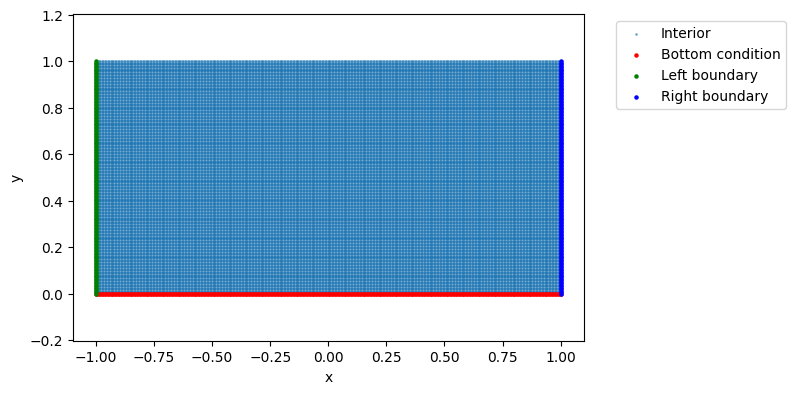

In [2]:
# Function to plot the domain setup
def plot_domain_setup(x_interior, t_interior, x_initial, t_initial, x_left, t_left, x_right, t_right):
    plt.figure(figsize=(8, 4))
    
    # Create meshgrid for plotting
    X,T = np.meshgrid(x_interior, t_interior)
    
    X_left, T_left = np.meshgrid(x_left, t_left)
    X_right, T_right = np.meshgrid(x_right, t_right)
    X_initial, T_initial = np.meshgrid(x_initial, t_initial)

    # Plot interior points
    plt.scatter(X, T, s=1, alpha=0.5, label='Interior')
    
    # Plot initial and boundary points
    plt.scatter(X_initial, T_initial, s=5, c='r', label='Bottom condition')
    plt.scatter(X_left, T_left, s=5, c='g', label='Left boundary')
    plt.scatter(X_right, T_right, s=5, c='b', label='Right boundary')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Plot the domain setup
plot_domain_setup(x_interior, y_interior, x_bottom, y_bottom, x_left, y_left, x_right, y_right)


In [8]:
class SF_KAN_Separable:
    def __init__(self, layer_dims, init_lr, k=3, r=10, D=1e-4):
        self.input_size = layer_dims[0]
        self.out_size = layer_dims[-1]
        self.r = r
        self.layer_dims = [self.input_size] + layer_dims[1:-1] + [self.r * self.out_size]
        self.model_x = KAN(layer_dims=self.layer_dims, k=k, const_spl=False, const_res=False, add_bias=True, grid_e=0.02, j='0')
        self.model_y = KAN(layer_dims=self.layer_dims, k=k, const_spl=False, const_res=False, add_bias=True, grid_e=0.02, j='0')
        self.D = D

        key1, key2 = jax.random.split(jax.random.PRNGKey(10))
        self.variables_x = self.model_x.init(key1, jnp.ones([1, 1]))
        self.variables_y = self.model_y.init(key2, jnp.ones([1, 1]))
        
        self.optimizer = optax.adam(learning_rate=init_lr, nesterov=True)
        self.opt_state_x = self.optimizer.init(self.variables_x['params'])
        self.opt_state_y = self.optimizer.init(self.variables_y['params'])

        self.train_losses = []

    def interpolate_moments(self, mu_old, nu_old, new_shape):
        old_shape = mu_old.shape
        old_j = old_shape[1]
        new_j = new_shape[1]
        
        old_indices = jnp.linspace(0, old_j - 1, old_j)
        new_indices = jnp.linspace(0, old_j - 1, new_j)

        interpolate_fn = lambda old_row: jnp.interp(new_indices, old_indices, old_row)

        mu_new = vmap(interpolate_fn)(mu_old)
        nu_new = vmap(interpolate_fn)(nu_old)
        
        return mu_new, nu_new

    def smooth_state_transition(self, old_state, params):
        adam_count = old_state[0].count
        adam_mu, adam_nu = old_state[0].mu, old_state[0].nu

        layer_keys = {k for k in adam_mu.keys() if k.startswith('layers_')}
        
        for key in layer_keys:
            c_shape = params[key]['c_basis'].shape
            mu_new0, nu_new0 = self.interpolate_moments(adam_mu[key]['c_basis'], adam_nu[key]['c_basis'], c_shape)
            adam_mu[key]['c_basis'], adam_nu[key]['c_basis'] = mu_new0, nu_new0

        adam_state = optax.ScaleByAdamState(adam_count, adam_mu, adam_nu)
        extra_state = optax.ScaleByScheduleState(adam_count)
        new_state = (adam_state, extra_state)

        return new_state

    @partial(jit, static_argnums=(0,))
    def predict(self, x, y):
        variables_x, variables_y = self.variables_x, self.variables_y
        preds, _ = self.forward_pass(variables_x, variables_y, x, y)
        return preds

    @partial(jit, static_argnums=(0,))
    def forward_pass(self, variables_x, variables_y, x, y):
        preds_x, spl_regs_x = self.model_x.apply(variables_x, x[:, None])
        preds_y, spl_regs_y = self.model_y.apply(variables_y, y[:, None])
        
        preds_x = preds_x.reshape(-1, self.out_size, self.r)
        preds_y = preds_y.reshape(-1, self.out_size, self.r)
        preds = jnp.einsum('ijk,ljk->ilj', preds_x, preds_y)

        spl_regs = spl_regs_x + spl_regs_y

        return preds, spl_regs

    @partial(jit, static_argnums=(0,))
    def loss_fn(self, variables_x, variables_y, x_interior, y_interior, x_left, y_left, x_right, y_right, x_bottom, y_bottom):
        # Compute physics residuals
        residuals = self.compute_residuals(variables_x, variables_y, x_interior, y_interior)
        physics_loss = jnp.mean(jnp.square(residuals))

        # Boundary losses
        preds_left, _ = self.forward_pass(variables_x, variables_y, x_left, y_left)   # Shape: (nx_left, ny_left, 1)
        preds_right, _ = self.forward_pass(variables_x, variables_y, x_right, y_right) # Shape: (nx_right, ny_right, 1)
        preds_bottom, _ = self.forward_pass(variables_x, variables_y, x_bottom, y_bottom) # Shape: (nx_bottom, 1, 1)

        # Left and right boundaries: u = -1
        left_loss = jnp.mean(jnp.square(preds_left + 1))
        right_loss = jnp.mean(jnp.square(preds_right + 1))

        # Bottom boundary: u = x^2 * cos(πx)
        bottom_exact = (x_bottom**2 * jnp.cos(jnp.pi * x_bottom))[:, None, None]  # Shape: (nx, 1, 1)
        bottom_loss = jnp.mean(jnp.square(preds_bottom - bottom_exact))

        boundary_loss = left_loss + right_loss + bottom_loss

        # Total loss
        total_loss = physics_loss + boundary_loss

        return total_loss, (physics_loss, boundary_loss)


    @partial(jit, static_argnums=(0,))
    def compute_residuals(self, variables_x, variables_y, x_interior, y_interior):
        def model_x_func(x):
            x_feat = self.model_x.apply(variables_x, x.reshape(-1, 1))[0]
            return x_feat.reshape(self.out_size, self.r)

        def model_y_func(y):
            y_feat = self.model_y.apply(variables_y, y.reshape(-1, 1))[0]
            return y_feat.reshape(self.out_size, self.r)

        def model_x_hess(x):
            return jacfwd(jacfwd(model_x_func))(x)

        def model_y_grad(y):
            return jacfwd(model_y_func)(y)

        x_feats = vmap(model_x_func)(x_interior)
        y_feats = vmap(model_y_func)(y_interior)
        x_hess = vmap(model_x_hess)(x_interior)
        y_grad = vmap(model_y_grad)(y_interior)

        u_x, u_y = x_feats[:, 0, :], y_feats[:, 0, :]
        d2u_x_dx2 = x_hess[:, 0, :]
        du_y_dy = y_grad[:, 0, :]

        u = jnp.einsum('ir,jr->ij', u_x, u_y)
        d2u_dx2 = jnp.einsum('ir,jr->ij', d2u_x_dx2, u_y)
        du_dy = jnp.einsum('ir,jr->ij', u_x, du_y_dy)

        # Compute the residual of the PDE
        residual = du_dy - self.D * d2u_dx2 + 5 * (u**3 - u)

        return residual

    @partial(jit, static_argnums=(0,))
    def loss(self, params_x, params_y, state_x, state_y, *args):
        variables_x = {'params': params_x, 'state': state_x}
        variables_y = {'params': params_y, 'state': state_y}
        return self.loss_fn(variables_x, variables_y, *args)

    @partial(jit, static_argnums=(0,))
    def train_step(self, params_x, params_y, state_x, state_y, opt_state_x, opt_state_y, *args):
        (loss_value, (physics_loss, boundary_loss)), grads = jax.value_and_grad(self.loss, has_aux=True, argnums=(0, 1))(
            params_x, params_y, state_x, state_y, *args
        )
        grads_x, grads_y = grads

        updates_x, opt_state_x = self.optimizer.update(grads_x, opt_state_x)
        updates_y, opt_state_y = self.optimizer.update(grads_y, opt_state_y)

        params_x = optax.apply_updates(params_x, updates_x)
        params_y = optax.apply_updates(params_y, updates_y)

        return params_x, params_y, opt_state_x, opt_state_y, loss_value, physics_loss, boundary_loss

    def train(self, num_epochs, x_interior, y_interior, x_bottom, y_bottom, x_left, y_left, x_right, y_right):
        params_x, state_x = self.variables_x['params'], self.variables_x['state']
        params_y, state_y = self.variables_y['params'], self.variables_y['state']
        opt_state_x, opt_state_y = self.opt_state_x, self.opt_state_y
        loss_history = []

        pbar = trange(num_epochs, smoothing=0.)
        for epoch in pbar:                
            params_x, params_y, opt_state_x, opt_state_y, loss_value, physics_loss, boundary_loss = self.train_step(
                params_x, params_y, state_x, state_y, opt_state_x, opt_state_y,
                x_interior, y_interior, x_left, y_left, x_right, y_right, x_bottom, y_bottom
            )
            loss_history.append(loss_value)

            if epoch % 10 == 0:
                pbar.set_postfix({
                    'Total Loss': f"{loss_value:.4e}",
                    'Physics Loss': f"{physics_loss:.4e}",
                    'Boundary Loss': f"{boundary_loss:.4e}"
                })
        
        self.variables_x = {'params': params_x, 'state': state_x}
        self.variables_y = {'params': params_y, 'state': state_y}
        return loss_history



In [ ]:
# Usage example:
layer_dims = [1, 5, 5, 1]
init_lr = 1e-3
k = 5
r = 10

model = SF_KAN_Separable(
    layer_dims=layer_dims,
    init_lr=init_lr,
    D=1e-4,
    k=k,
    r=r
)

num_epochs = 100000
loss_history = model.train(
    num_epochs,
    x_interior, y_interior,
    x_bottom, y_bottom,
    x_left, y_left,
    x_right, y_right
)


100%|██████████| 1/1 [00:33<00:00, 33.25s/it, Total Loss=3.0569e+00, Physics Loss=8.3876e-02, Boundary Loss=2.9731e+00]


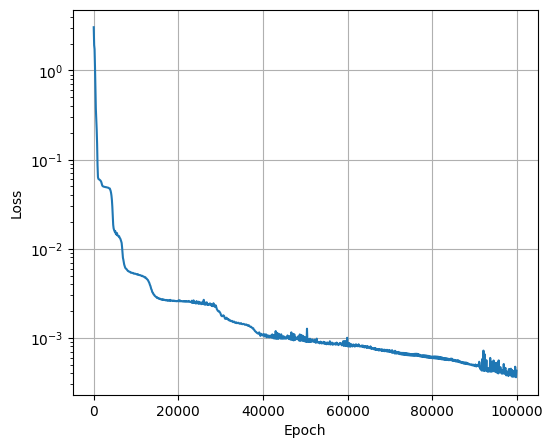

In [10]:
# Plot loss history
def plot_loss_history(loss_history):
    plt.figure(figsize=(6, 5))
    epochs = range(0, len(loss_history), 100)
    plt.plot(epochs, loss_history[::100])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Use log scale for y-axis
    plt.grid(True)
    plt.show()

plot_loss_history(loss_history)


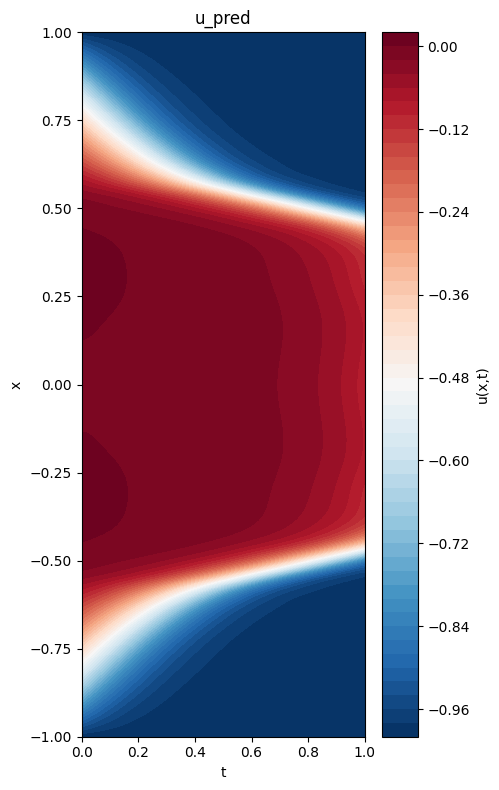

In [15]:
# Generate solution
nx_plot, nt_plot = nx, ny
x_plot = np.linspace(-1, 1, nx_plot)
t_plot = np.linspace(0, 1, nt_plot)
X_mesh, T_mesh = np.meshgrid(x_plot, t_plot)
u_pred = model.predict(x_plot, t_plot).squeeze().T


# Plot the predicted solution
plt.figure(figsize=(5, 8))
plt.contourf(T_mesh, X_mesh, u_pred, levels=50, cmap='RdBu_r')
plt.colorbar(label='u(x,t)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('u_pred')
plt.tight_layout()
plt.show()


In [ ]:
# Create dictionary with all field data
output_data = {
    'x': x_plot,
    't': t_plot,
    'u': u_pred,
    'D': 1e-4
}

# Save data
np.save(f'./data/allen_cahn_spikan_nx{nx}_nt{ny}_{layer_dims}_epochs{num_epochs}_k{k}_r{r}.npy', output_data)


In [7]:
def count_trainable_params(variables_x, variables_y):
    # Flatten the parameter trees
    flat_params_x, _ = jax.tree_util.tree_flatten(variables_x['params'])
    flat_params_y, _ = jax.tree_util.tree_flatten(variables_y['params'])
    
    # Sum the number of elements in each parameter array for both models
    total_params_x = sum(p.size for p in flat_params_x)
    total_params_y = sum(p.size for p in flat_params_y)
    
    # Total trainable parameters in the entire separable model
    total_params = total_params_x + total_params_y
    return total_params

# Assuming `variables_x` and `variables_y` have been initialized in your model
num_params = count_trainable_params(model.variables_x, model.variables_y)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 1640
